In [1]:
import os, glob, random
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.ndimage import binary_opening, binary_closing
import imageio 
import cv2
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch.nn.functional as F

/home/jeonk636/micromamba/envs/DeepEcho/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


# Question 1

### DICOM 슬라이스 읽어오기

In [3]:
fname = 'blind/000001.dcm'
tmp_dcm = pydicom.dcmread(fname)

tmp_dcm

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 226
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.304394017511048013117416969472184186476
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.3.100.9.4
(0002,0013) Implementation Version Name         SH: 'MATLAB IPT 9.4'
(0002,0016) Source Application Entity Title     AE: 'MAROTECH'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'GSI MONO']
(0008,0012) Instance Creation Date              DA: '20180427'
(0008,0013) Instance Creation Time              TM: '102217'
(0008,0016) S

- (0028,0030) Pixel Spacing                       DS: [0.832031, 0.832031]
- (0018,0050) Slice Thickness                     DS: '2.5'

In [4]:
row_spacing, col_spacing = tmp_dcm.PixelSpacing  
slice_spacing = float(tmp_dcm.SliceThickness)

In [5]:
print(row_spacing, col_spacing, slice_spacing)

0.832031 0.832031 2.5


In [6]:
dx = col_spacing/10 
dy = row_spacing/10 
dz = slice_spacing/10
print(dx, dy, dz)

0.0832031 0.0832031 0.25


In [7]:
folder = 'blind'
fnames = sorted(
    [f for f in os.listdir(folder) if f.endswith('.dcm')],
    key=lambda f: int(pydicom.dcmread(os.path.join(folder, f)).InstanceNumber)
)
slices = [pydicom.dcmread(os.path.join(folder, f)) for f in fnames]
volume = np.stack([s.pixel_array for s in slices], axis=2)

In [8]:
H, W, N = volume.shape
x = np.arange(W) * dx  # 열
y = np.arange(H) * dy  # 행
z = np.arange(N) * dz  # 슬라이스

In [9]:
axial = N//2 
sagittal = W//2 
coronal = H//2 

print(axial, sagittal, coronal)

62 256 256


In [10]:
volume.shape

(512, 512, 125)

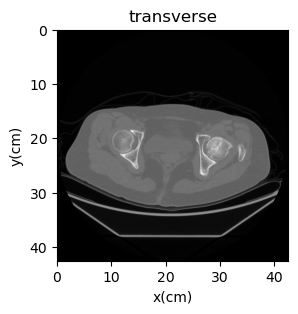

In [11]:
cx, cy = W/2, H/2
r = min(cx, cy)
yy, xx = np.ogrid[:H, :W]
mask = (xx-cx)**2 + (yy-cy)**2 > r**2
pad_val = getattr(slices[0], 'PixelPaddingValue', volume.min())

img_ax = volume[:, :, axial].copy()
img_ax = np.maximum(img_ax, 0) 

plt.figure(figsize=(3,3))
plt.imshow(img_ax, cmap='gray', extent=[x.min(), x.max(), y.max(), y.min()],)
plt.gca().set_aspect('equal')
plt.title(f'transverse')
plt.xlabel('x(cm)'); plt.ylabel('y(cm)')
plt.show()

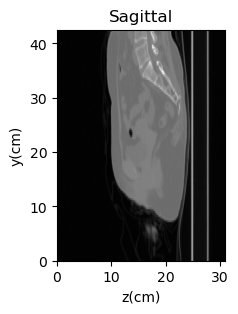

In [12]:
img_sag = volume[:, sagittal, :].copy()
mask_sag = np.tile(mask[:, sagittal][:, None], (1, N))
img_sag[mask_sag] = pad_val
img_sag_t = img_sag.T
plt.figure(figsize=(3,3))
plt.imshow(img_sag_t, cmap='gray', extent=[z.min(), z.max(), y.min(), y.max()],)
plt.gca().set_aspect('equal')
plt.title('Sagittal')
plt.xlabel('z(cm)'); plt.ylabel('y(cm)')
plt.show()

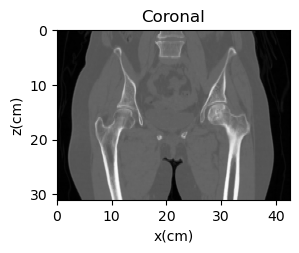

In [13]:
img_cor = volume[coronal, :, :].T.copy()
mask_cor = np.tile(mask[coronal, :][None, :], (N, 1))
img_cor[mask_cor] = pad_val
plt.figure(figsize=(3,3))
plt.imshow(img_cor, cmap='gray', extent=[x.min(), x.max(), z.max(), z.min()],)
plt.gca().set_aspect('equal')
plt.title(f'Coronal')
plt.xlabel('x(cm)'); plt.ylabel('z(cm)')
plt.show()

# Question 4

Pick one slice image, and from the slice image, extract only edges using 2D wavelet technique.

### Transverse

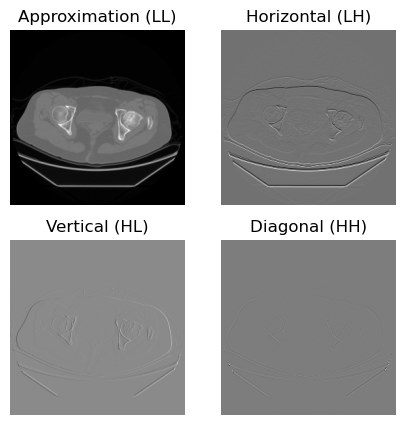

In [14]:
coeffs2 = pywt.dwt2(img_ax, 'haar')
LL, (LH, HL, HH) = coeffs2

fig, axes = plt.subplots(2,2, figsize=(5,5))
axes[0,0].imshow(LL, cmap='gray'); axes[0,0].set_title('Approximation (LL)')
axes[0,1].imshow(LH, cmap='gray'); axes[0,1].set_title('Horizontal (LH)')
axes[1,0].imshow(HL, cmap='gray'); axes[1,0].set_title('Vertical (HL)')
axes[1,1].imshow(HH, cmap='gray'); axes[1,1].set_title('Diagonal (HH)')
for ax in axes.flatten(): ax.axis('off')
plt.show()

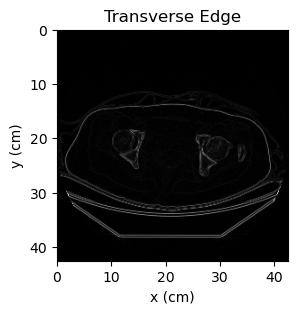

In [15]:
edge_img = np.sqrt(LH**2 + HL**2 + HH**2)

plt.figure(figsize=(3,3))
plt.imshow(edge_img, cmap='gray', extent=[x.min(), x.max(), y.max(), y.min()],)
plt.gca().set_aspect('equal')
plt.xlabel('x (cm)'); plt.ylabel('y (cm)')
plt.title('Transverse Edge')
plt.show()


### Sagittal

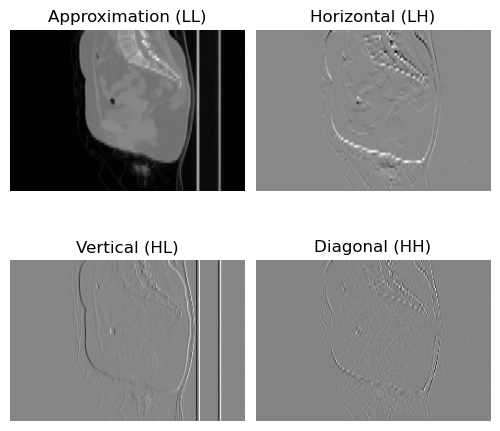

In [16]:
coeffs2 = pywt.dwt2(img_sag_t, 'haar')
LL_s, (LH_s, HL_s, HH_s) = coeffs2

extent_sag = [z.min()*2, z.max()*2, y.max(), y.min()]

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes[0,0].imshow(LL_s, cmap='gray', extent=extent_sag, aspect='equal')
axes[0,0].set_title('Approximation (LL)')

axes[0,1].imshow(LH_s, cmap='gray',extent=extent_sag, aspect='equal')
axes[0,1].set_title('Horizontal (LH)')

axes[1,0].imshow(HL_s, cmap='gray', extent=extent_sag, aspect='equal')
axes[1,0].set_title('Vertical (HL)')

axes[1,1].imshow(HH_s, cmap='gray', extent=extent_sag, aspect='equal')
axes[1,1].set_title('Diagonal (HH)')

for ax in axes.flatten(): ax.axis('off')

fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0.02, right=0.98, top=0.95, bottom=0.05)

plt.show()


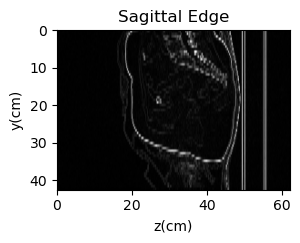

In [17]:
edge_sag = np.sqrt(LH_s**2 + HL_s**2 + HH_s**2)

plt.figure(figsize=(3, 3))
plt.imshow(edge_sag, cmap='gray', extent=[z.min()*2, z.max()*2, y.max(), y.min()],)
plt.gca().set_aspect('equal')
plt.xlabel('z(cm)'); plt.ylabel('y(cm)')
plt.title('Sagittal Edge')
plt.show()


### Coronal

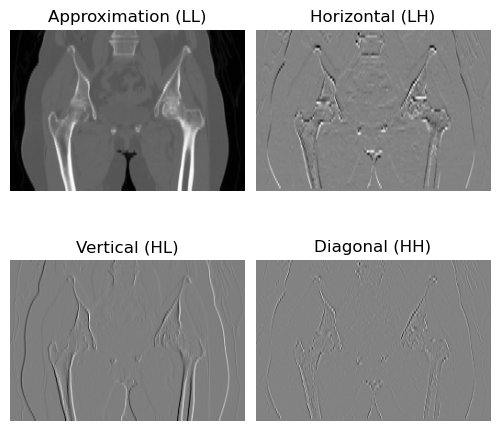

In [18]:
coeffs2 = pywt.dwt2(img_cor, 'haar')
LL_s, (LH_s, HL_s, HH_s) = coeffs2

extent_sag = [z.min()*2, z.max()*2, y.max(), y.min()]

fig, axes = plt.subplots(2, 2, figsize=(5, 5))
axes[0,0].imshow(LL_s, cmap='gray', extent=extent_sag, aspect='equal')
axes[0,0].set_title('Approximation (LL)')

axes[0,1].imshow(LH_s, cmap='gray',extent=extent_sag, aspect='equal')
axes[0,1].set_title('Horizontal (LH)')

axes[1,0].imshow(HL_s, cmap='gray', extent=extent_sag, aspect='equal')
axes[1,0].set_title('Vertical (HL)')

axes[1,1].imshow(HH_s, cmap='gray', extent=extent_sag, aspect='equal')
axes[1,1].set_title('Diagonal (HH)')

for ax in axes.flatten(): ax.axis('off')

fig.subplots_adjust(wspace=0.05, hspace=0.05, left=0.02, right=0.98, top=0.95, bottom=0.05)

plt.show()
plt.show()

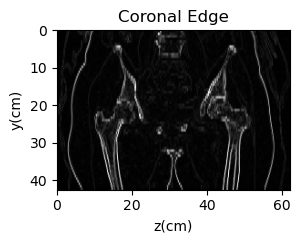

In [19]:
edge_sag = np.sqrt(LH_s**2 + HL_s**2 + HH_s**2)

plt.figure(figsize=(3, 3))
plt.imshow(edge_sag, cmap='gray', extent=[z.min()*2, z.max()*2, y.max(), y.min()],)
plt.gca().set_aspect('equal')
plt.xlabel('z(cm)'); plt.ylabel('y(cm)')
plt.title('Coronal Edge')
plt.show()

# Question 3

### transverse에서 bone segmentation

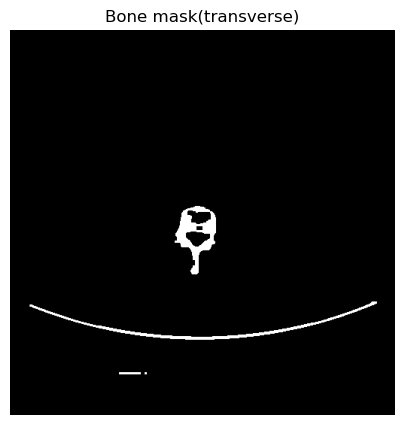

In [20]:
axial = 0
target_slice = volume[:, :, axial]

ds = slices[0]

slice_raw = target_slice.astype(np.float32)
slice_hu = slice_raw * ds.RescaleSlope + ds.RescaleIntercept

slice_hu = np.clip(slice_hu, -1024, 2000)

bone_mask = slice_hu >= 150

bone_mask[mask] = False

bone_mask = binary_opening(bone_mask, structure=np.ones((3,3)))
bone_mask = binary_closing(bone_mask, structure=np.ones((5,5)))

plt.figure(figsize=(5,5))
plt.imshow(bone_mask, cmap='gray')
plt.title('Bone mask(transverse)')
plt.axis('off')
plt.show()


In [21]:
bone_mask.shape

(512, 512)

### 문제 5번에서 활용하기 위해 따로 저장

In [22]:
H, W, N = volume.shape
ds = slices[0]
transverse_masks = np.zeros((H, W, N), dtype=bool)

for i in range(N):
    raw = volume[:, :, i].astype(np.float32)
    hu  = raw * ds.RescaleSlope + ds.RescaleIntercept
    hu  = np.clip(hu, -1024, 2000)
    mask_i = hu >= 150
    mask_i[mask] = False
    mask_i = binary_opening(mask_i, structure=np.ones((3,3)))
    mask_i = binary_closing(mask_i, structure=np.ones((5,5)))
    transverse_masks[:, :, i] = mask_i

print(transverse_masks.shape)

(512, 512, 125)


### bone segmentation 결과 확인용 저장

In [ ]:
os.makedirs('transverse_masks', exist_ok=True)

H, W, N = transverse_masks.shape
for i in range(N):
    mask_i = transverse_masks[:, :, i].astype(np.uint8) * 255
    filename = f'transverse_masks/mask_{i:03d}.png'
    imageio.imwrite(filename, mask_i)

### Sagittal

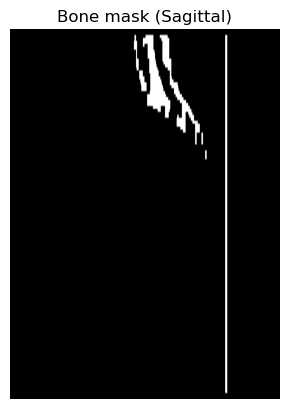

In [23]:
sagittal = 256
target_slice = volume[:, sagittal, :]

ds = slices[0]
slice_hu = target_slice.astype(np.float32) * ds.RescaleSlope + ds.RescaleIntercept
slice_hu = np.clip(slice_hu, -1024, 2000)

bone_mask = slice_hu >= 150

outside = mask[:, sagittal]
bone_mask[outside, :] = False

bone_mask = binary_opening(bone_mask, structure=np.ones((3,3)))
bone_mask = binary_closing(bone_mask, structure=np.ones((5,5)))
mask_sag_t = bone_mask.T

plt.imshow(mask_sag_t, cmap='gray', extent=[z.min(), z.max(), y.max(), y.min()])
plt.gca().set_aspect('equal')
plt.title('Bone mask (Sagittal)')
plt.axis('off')
plt.show()

In [24]:
sagittal_masks = np.zeros((H, N, W), dtype=bool)

for j in range(W):
    slice_raw = volume[:, j, :].astype(np.float32)
    slice_hu = slice_raw * ds.RescaleSlope + ds.RescaleIntercept
    slice_hu = np.clip(slice_hu, -1024, 2000)

    bone_mask = slice_hu >= 150 
    bone_mask[mask[:, j], :] = False 
    bone_mask = binary_opening(bone_mask, np.ones((3,3)))
    bone_mask = binary_closing(bone_mask, np.ones((5,5)))

    sagittal_masks[:, :, j] = bone_mask

print(sagittal_masks.shape)

# os.makedirs('sagittal_masks', exist_ok=True)
# for j in range(W):
#     img = (sagittal_masks[:, :, j].astype(np.uint8) * 255)
#     imageio.imwrite(f'sagittal_masks/mask_{j:03d}.png', img)


(512, 125, 512)


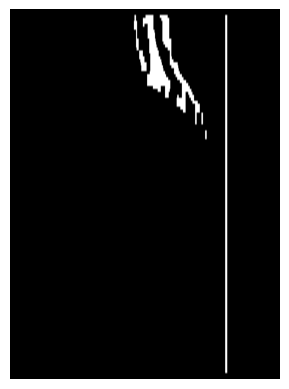

In [25]:
j = 256
mask_sag_t = sagittal_masks[:, :, j].T
plt.imshow(mask_sag_t, cmap='gray', extent=[z.min(), z.max(), y.max(), y.min()],)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

### Coronal

(512, 125, 512)


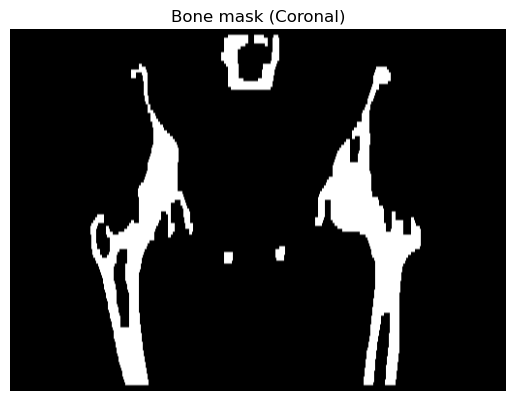

In [26]:
outside_x = mask[coronal, :] 
mask_cor_plane = np.tile(outside_x[:, None], (1, N))

coronal_masks = np.zeros((W, N, H), dtype=bool)
for y in range(H): 
    hu = volume[y, :, :].astype(np.float32) * ds.RescaleSlope + ds.RescaleIntercept
    hu = np.clip(hu, -1024, 2000)
    mask_y = hu >= 150 

    mask_y[mask_cor_plane] = False 

    mask_y = binary_opening(mask_y, np.ones((3,3)))
    mask_y = binary_closing(mask_y, np.ones((5,5)))

    coronal_masks[:, :, y] = mask_y 

print(coronal_masks.shape)

# os.makedirs('coronal_masks', exist_ok=True)
# for y in range(H):
#     img = coronal_masks[:, :, y].astype(np.uint8) * 255
#     imageio.imwrite(f'coronal_masks/mask_{y:03d}.png', img)

mask_cor_t = coronal_masks[:, :, coronal].T 
plt.imshow(mask_cor_t, cmap='gray',
           extent=[x.min(), x.max(), z.max(), z.min()],
           origin='upper')
plt.gca().set_aspect('equal')
plt.title('Bone mask (Coronal)')
plt.axis('off')
plt.show()


# Question 5

학습을 위한 'transverse' 이미지 저장

In [ ]:
os.makedirs('transverse_png', exist_ok=True)

for i in range(N):
    raw = volume[:, :, i].astype(np.float32)
    hu = raw * ds.RescaleSlope + ds.RescaleIntercept
    hu_clipped = np.clip(hu, -1024, 2000)
    img_8u = ((hu_clipped + 1024) / (2000 + 1024) * 255).astype(np.uint8)
    cv2.imwrite(f'transverse_png/slice_{i:03d}.png', img_8u)

In [27]:
def load_sample(df):
    row = df.sample(1).iloc[0]
    img = cv2.imread(row['img'])[..., ::-1]
    mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE) > 0

    img = cv2.resize(img, (512, 512))
    mask = cv2.resize(mask.astype(np.uint8), (512, 512), interpolation=cv2.INTER_NEAREST) > 0

    ys, xs = np.where(mask)
    pts = np.array([[int(x), int(y)] for x, y in zip(xs, ys)])
    if len(pts) > 6:
        pts = pts[np.random.choice(len(pts), 6, replace=False)]
    pts = pts[None, ...] 
    labels = np.ones((1, pts.shape[1]), dtype=np.int32)

    return img, mask, pts, labels

In [28]:
IMG_DIR  = 'transverse_png'
MASK_DIR = 'transverse_masks'

In [29]:
all_imgs = sorted(glob.glob(os.path.join(IMG_DIR, 'slice_*.png')))
all_masks = [os.path.join(MASK_DIR, f"mask_{os.path.basename(p).split('_')[1]}") for p in all_imgs]
df = pd.DataFrame({'img': all_imgs, 'mask': all_masks})

train_df = df.sample(frac=0.8, random_state=42).reset_index(drop=True)
test_df = df.drop(train_df.index).reset_index(drop=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CTSliceDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['img'])[...,::-1]
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)>0
        
        img = cv2.resize(img, (512,512))
        mask = cv2.resize(mask.astype(np.uint8),(512,512), interpolation=cv2.INTER_NEAREST)>0
        
        # 랜덤 포인트 8개 추출
        ys, xs = np.where(mask)
        pts = np.stack([xs, ys], axis=1)
        if len(pts)>8:
            pts = pts[np.random.choice(len(pts), 8, replace=False)]
        pts = pts[None,...].astype(np.int32)
        labels = np.ones((1, pts.shape[1]),dtype=np.int32)
        
        return img, mask, pts, labels

train_loader = DataLoader(CTSliceDataset(train_df), batch_size=4, shuffle=True, drop_last=True)

predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large", device=device)
predictor.model.sam_mask_decoder.train(True)
predictor.model.sam_prompt_encoder.train(True)

optimizer = AdamW(predictor.model.parameters(),lr=1e-3, weight_decay=1e-4)
total_steps = len(train_loader)*15
scheduler = OneCycleLR(optimizer, max_lr=1e-3, total_steps=total_steps, pct_start=0.1, anneal_strategy='cos')
scaler = torch.cuda.amp.GradScaler()

/home/jeonk636/micromamba/envs/DeepEcho/lib/python3.10/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


### 학습

In [ ]:
EPOCHS = 15

for epoch in range(EPOCHS):
    running_loss = 0.0
    for imgs, masks, pts_batch, labels_batch in train_loader:
        # batch 차원에서 각 샘플별 forward
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            batch_loss = 0.0
            for img, mask, pts, labels in zip(imgs, masks, pts_batch, labels_batch):
                predictor.set_image(img.cpu().numpy())
                
                sparse_emb, dense_emb = predictor.model.sam_prompt_encoder(
                    points=(torch.tensor(pts, device=device), torch.tensor(labels,device=device)),
                    boxes=None, masks=None
                )
                im_emb = predictor._features["image_embed"][-1].unsqueeze(0)
                high_feats = [f[-1].unsqueeze(0) for f in predictor._features["high_res_feats"]]
                
                low_masks, scores, _, _ = predictor.model.sam_mask_decoder(
                    image_embeddings = im_emb,
                    image_pe = predictor.model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings = sparse_emb,
                    dense_prompt_embeddings = dense_emb,
                    multimask_output = False,
                    repeat_image = False,
                    high_res_features = high_feats,
                )
                
                gt = torch.tensor(mask.float(), device=device).unsqueeze(0)
                up = F.interpolate(low_masks, size=gt.shape[-2:], mode='bilinear', align_corners=False)
                pred = torch.sigmoid(up)[0,0]
                
                loss = - (gt * torch.log(pred+1e-6) + (1-gt) * torch.log(1-pred+1e-6)).mean()
                batch_loss += loss
            
            batch_loss = batch_loss / imgs.size(0)
            scaler.scale(batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += batch_loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} loss: {running_loss/len(train_loader):.4f}")

torch.save(predictor.model.state_dict(),"sam2_ct_finetuned2.pth")

/home/jeonk636/micromamba/envs/DeepEcho/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/tmp/ipykernel_363785/3347254541.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points=(torch.tensor(pts,    device=device),
/tmp/ipykernel_363785/3347254541.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(labels,device=device)),
/tmp/ipykernel_363785/3347254541.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

Epoch 1/15 loss: 0.0960
Epoch 2/15 loss: 0.0151
Epoch 3/15 loss: 0.0115
Epoch 4/15 loss: 0.0087
Epoch 5/15 loss: 0.0079
Epoch 6/15 loss: 0.0075
Epoch 7/15 loss: 0.0073
Epoch 8/15 loss: 0.0072
Epoch 9/15 loss: 0.0066
Epoch 10/15 loss: 0.0061
Epoch 11/15 loss: 0.0059
Epoch 12/15 loss: 0.0058
Epoch 13/15 loss: 0.0057
Epoch 14/15 loss: 0.0057
Epoch 15/15 loss: 0.0056


In [30]:
df = pd.DataFrame({'img': all_imgs, 'mask': all_masks})
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

### '판'이 segmentation 되는 문제가 있음

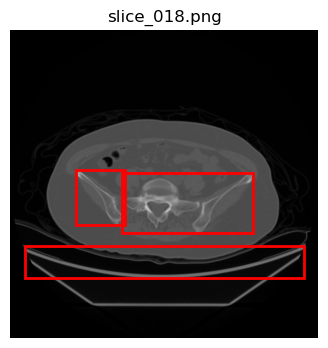

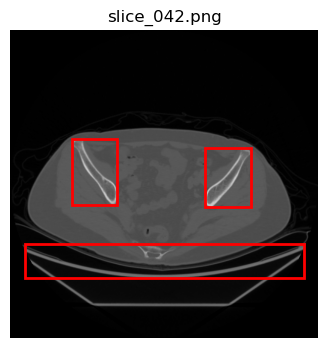

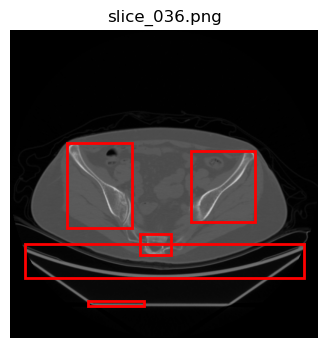

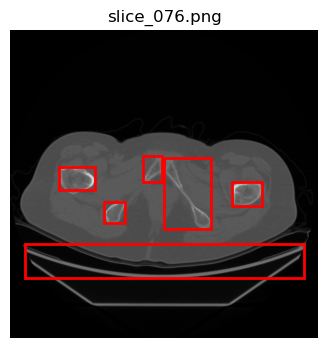

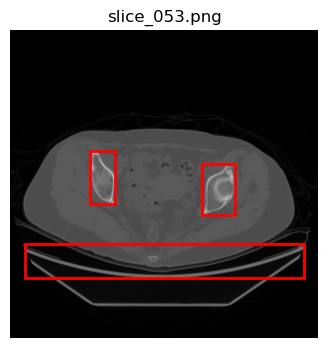

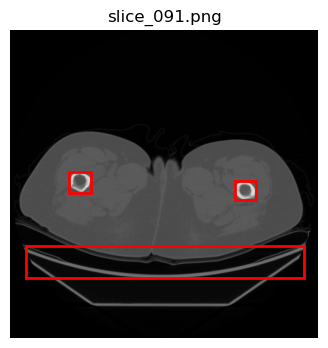

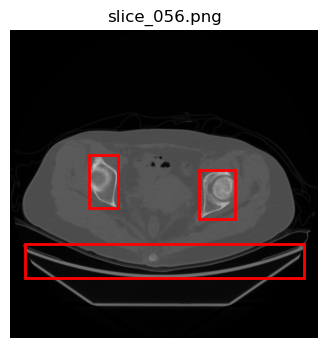

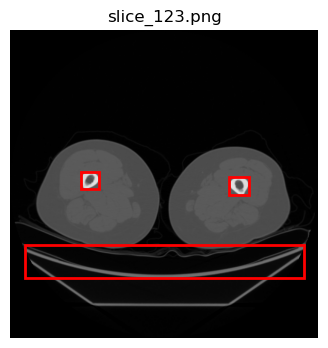

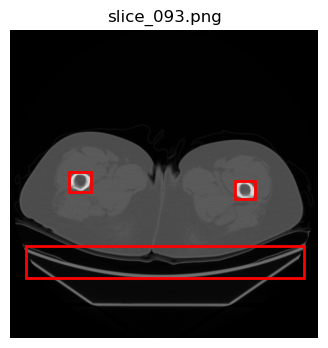

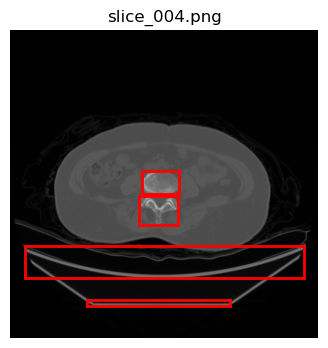

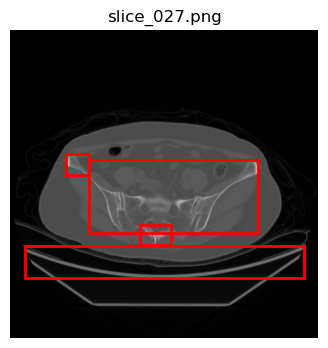

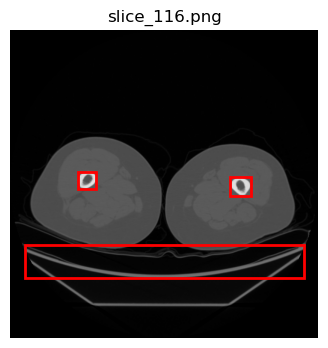

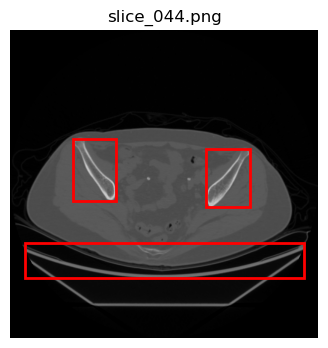

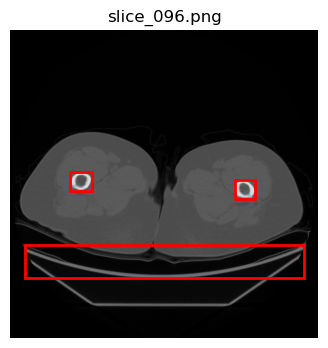

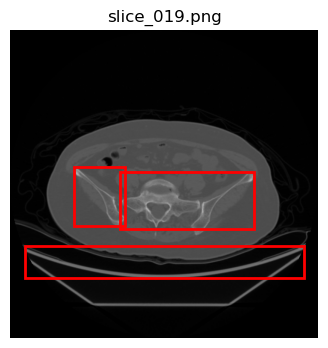

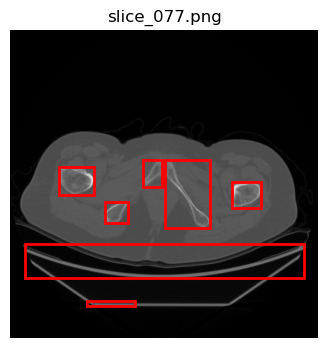

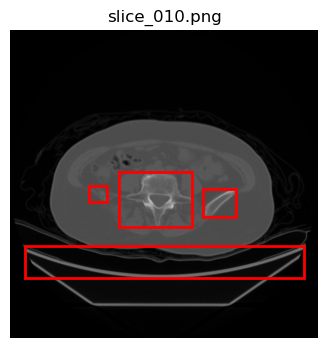

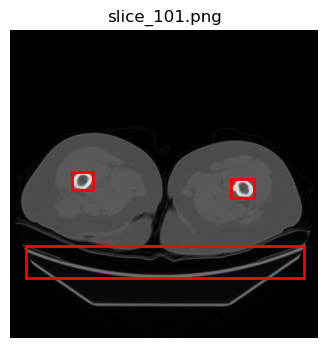

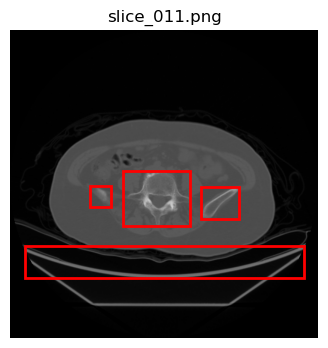

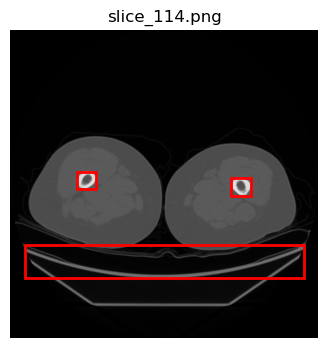

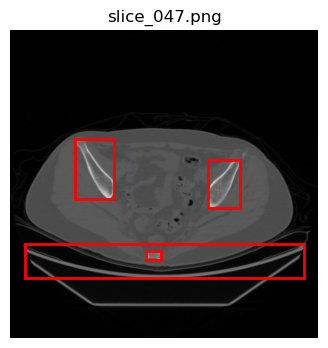

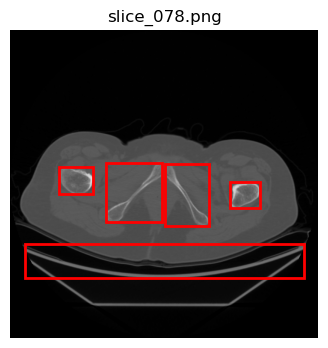

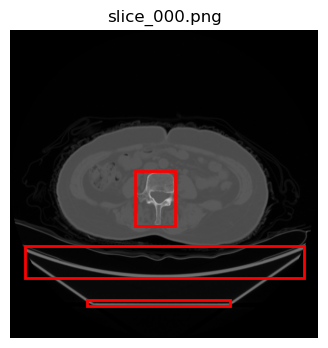

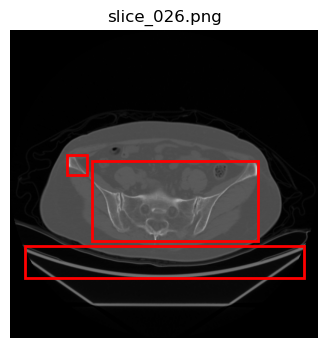

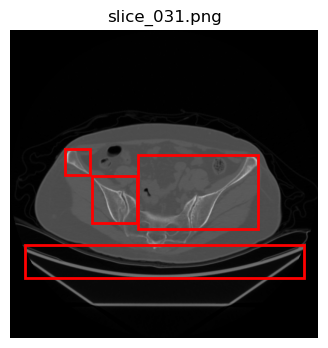

In [ ]:
ckpt = torch.load("sam2_ct_finetuned2.pth", map_location=device)
predictor.model.load_state_dict(ckpt)

predictor.model.eval()

for _, row in test_df.iterrows():
    img = cv2.imread(row['img'])[...,::-1]
    img = cv2.resize(img,(512,512))
    predictor.set_image(img)
    
    masks, scores, _ = predictor.predict( box=None, point_coords=None, multimask_output=True)
    scores = scores.flatten()
    
    # 상위 2개 mask
    top2 = np.argsort(scores)[::-1][:2]
    merged = np.any(masks[top2], axis=0).astype(np.uint8)
    
    # 연결 컴포넌트, area‐adaptive threshold
    nlab, labmap = cv2.connectedComponents(merged)
    total_px = merged.sum()
    min_px = max(200, int(total_px*0.03))
    
    bboxes = []
    for lab in range(1, nlab):
        ys, xs = np.where(labmap==lab)
        if len(xs)<min_px: continue
        bboxes.append((xs.min(), ys.min(), xs.max(), ys.max()))
    
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap='gray')
    for x1,y1,x2,y2 in bboxes:
        plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, edgecolor='r', facecolor='none', lw=2))
    plt.title(os.path.basename(row['img']))
    plt.axis('off')
    plt.show()

### 화면 아래 20% 영역 및 지나치게 가로로 긴 박스를 필터링하여 문제 해결

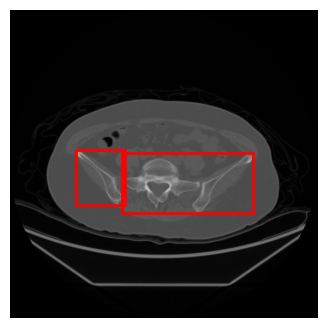

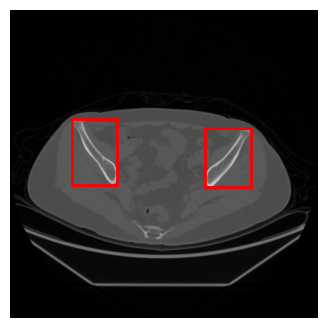

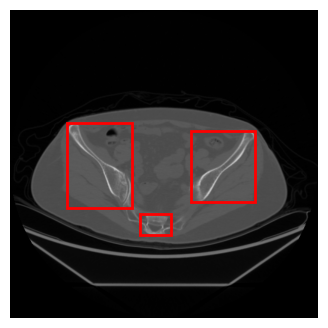

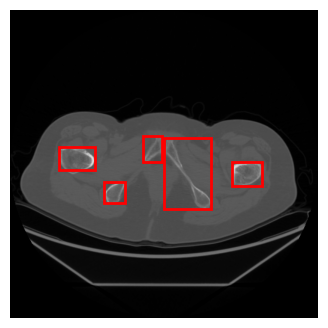

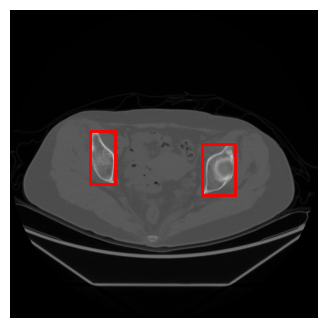

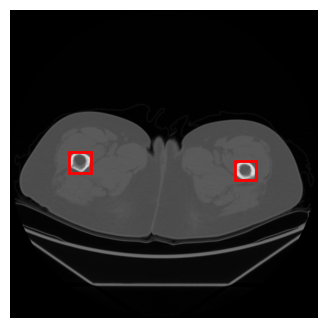

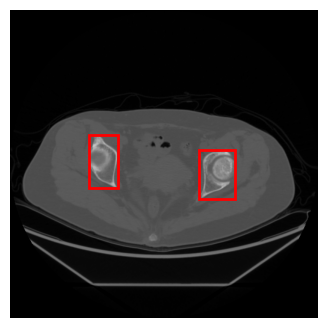

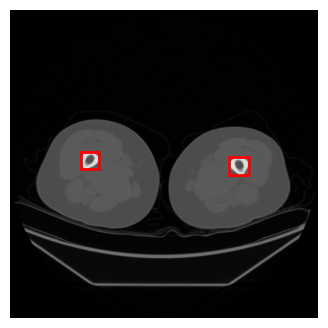

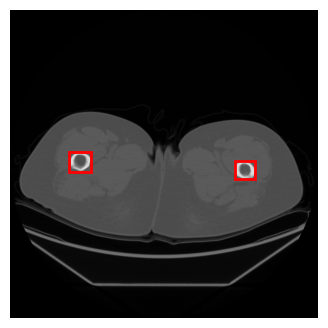

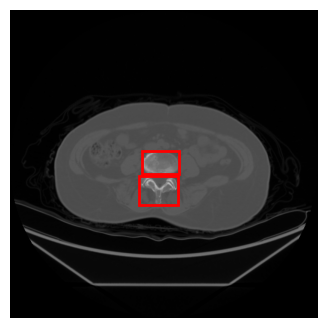

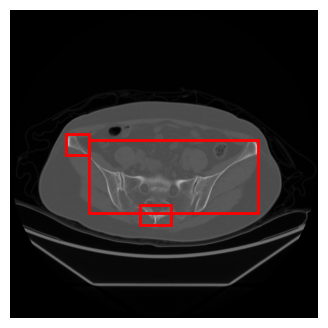

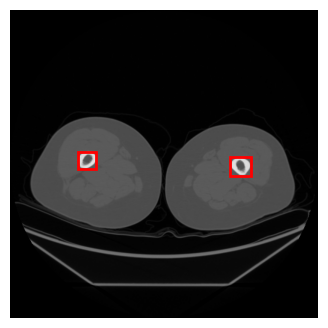

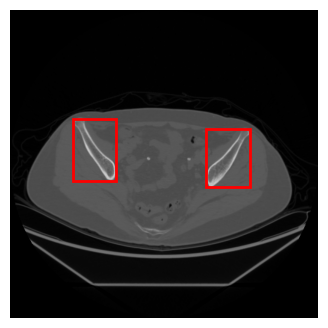

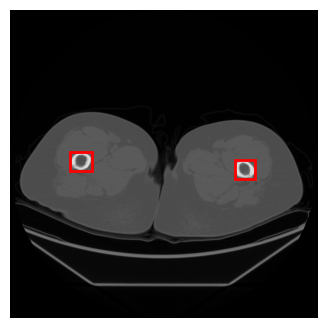

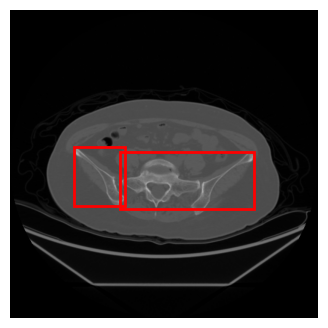

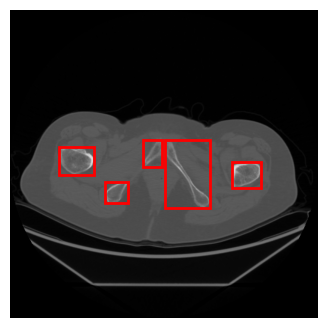

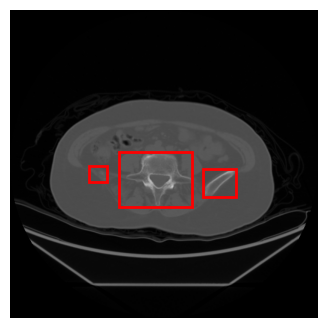

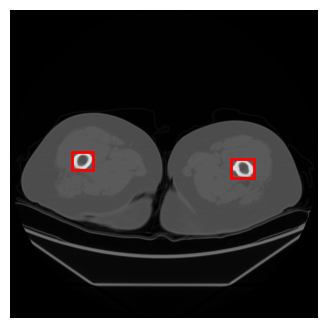

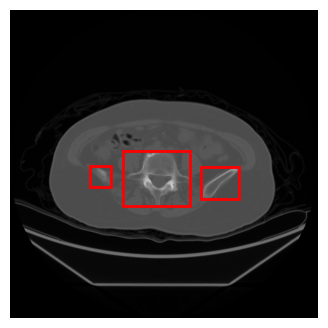

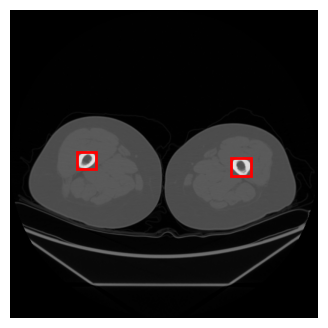

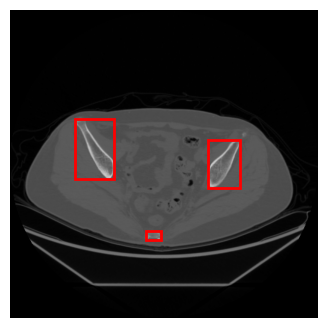

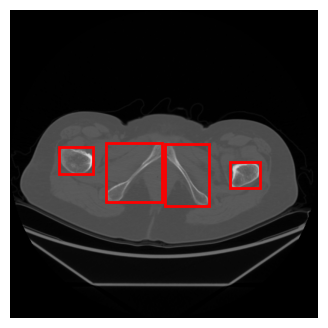

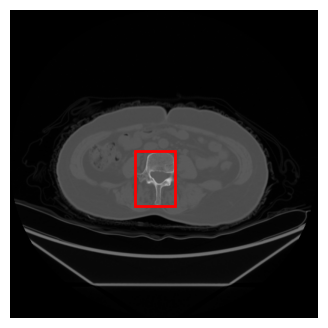

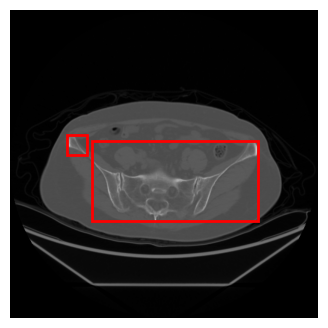

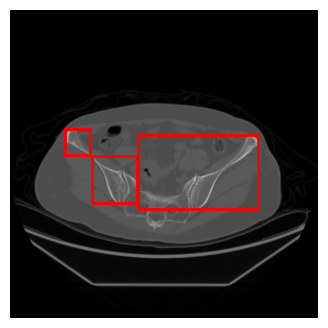

In [ ]:
ckpt = torch.load("sam2_ct_finetuned2.pth", map_location=device)
predictor.model.load_state_dict(ckpt)

predictor.model.eval()

for _, row in test_df.iterrows():
    img = cv2.imread(row['img'])[..., ::-1]
    img = cv2.resize(img, (512, 512))
    predictor.set_image(img)

    masks, scores, _ = predictor.predict(box=None, point_coords=None, multimask_output=True)
    scores = scores.flatten()

    top2   = np.argsort(scores)[::-1][:2]
    merged = np.any(masks[top2], axis=0).astype(np.uint8)

    nlab, labmap = cv2.connectedComponents(merged)
    total_px = merged.sum()
    min_px = max(200, int(total_px * 0.03))

    bboxes = []
    for lab in range(1, nlab):
        ys, xs = np.where(labmap == lab)
        if len(xs) < min_px:
            continue
        x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
        bboxes.append((x1, y1, x2, y2))

    # 아래쪽 20% , 지나치게 가로로 긴 성분 필터
    h_img = img.shape[0]
    y_threshold = h_img * 0.8
    filtered = []
    for x1, y1, x2, y2 in bboxes:
        w, h = x2 - x1, y2 - y1
        if y1 > y_threshold: # 아래 20% 이하
            continue
        if w / h > 5: # 지나치게 가로로 긴
            continue
        filtered.append((x1, y1, x2, y2))

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    for x1, y1, x2, y2 in filtered:
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor="r", facecolor="none", lw=2))
    plt.axis("off")
    plt.show()